In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functionst import * 
import numpy as np
%matplotlib inline

In [4]:
# Dataset1: Client Profiles: Demographics like age, gender, and account details of our clients.
file_path='data/df_final_demo.txt'
df_clients = pd.read_csv(file_path, delimiter=',')

In [5]:
# Dataset2: Digital Footprints pt1 & pt2: 
# A detailed trace of client interactions online, divided into two parts: pt_1 and pt_2. 
# It’s recommended to merge these two files prior to a comprehensive data analysis.
file_path='data/df_final_web_data_pt_1.txt'
df2 = pd.read_csv(file_path, delimiter=',')
file_path = "Data/df_final_web_data_pt_2.txt"
df3 = pd.read_csv(file_path, delimiter=',')
df_concat = pd.concat([df2, df3])  # Concatenated 

In [6]:
#Dataset 3: Experiment Roster: A list revealing which clients were part of the grand experiment.
file_path='data/df_final_experiment_clients.txt'
df_roster = pd.read_csv(file_path, delimiter=',')

Cleaning df_Clients

Check for Duplicates

In [7]:
df_clients.duplicated().sum() # Check

0

In [8]:
# Rename columns
df_clients.rename(columns={"clnt_tenure_yr": "client_tenure_yr",
                           "clnt_tenure_mnth":"client_tenure_mnth",
                           "clnt_age":"client_age",
                           "gendr":"gender",
                           "bal":"balance"
                           }, inplace=True)

In [ ]:
# Checking for NaN Rows
nan_rows = df_clients[df_clients.isna().any(axis=1)]
# Drop NaN Values with more many NaNs
df_clients.dropna(thresh=4,inplace=True)
# Fill NaN in client age
df_clients["client_age"].fillna(df_clients["client_age"].mean(),inplace=True)

# Drop NaN Values with more many NaNs 
df_clients.dropna(thresh=4,inplace=True)

# Fill NaN in client age
df_clients["client_age"].fillna(df_clients["client_age"].mean(),inplace=True)

# Filled the Client tenure yr with NaN when Client age < then tenure
df_clients.loc[df_clients["client_tenure_yr"] > df_clients["client_age"], "client_tenure_yr"] = np.nan

In [10]:
# Defining age Group and Assigning to client Data

df_clients["client_age_group"] = df_clients["client_age"].apply(age_group) # Age group aus Functions

Clean df_concat

In [12]:
# Transformed DATETIME
df_concat["date_time"] = pd.to_datetime(df_concat["date_time"])

In [15]:
df_concat.duplicated().sum()

10764

Joined Clients and Joined DC_Concat with Roster

In [16]:
# Joined Clients with the Roster an dropped the NaN Values
df_client_joined = pd.merge(df_clients,df_roster, how="left", on="client_id")

In [43]:
# Joined DF Concat with the Roster and dropped the duplicates
df_concat_joined = pd.merge(df_concat,df_roster, on="client_id", how="left")
df_concat_joined.dropna(subset="Variation",inplace=True)
df_concat_joined.drop_duplicates(inplace=True)
df_concat_joined['year_month'] = df_concat_joined['date_time'].dt.to_period('M') # Added year


In [20]:
""" Add a column if the client finished the process

# Identify the client_ids that have a "finished" step
clients_with_finished = df_concat_joined[df_concat_joined['process_step'] == 'confirm']['client_id']

# Using map to replace boolean values
df_client_joined['finished'] = df_client_joined["client_id"].isin(clients_with_finished).map({True:"yes",False:"no"})

df_client_joined["finished"].unique()"""

' Add a column if the client finished the process\n\n# Identify the client_ids that have a "finished" step\nclients_with_finished = df_concat_joined[df_concat_joined[\'process_step\'] == \'confirm\'][\'client_id\']\n\n# Using map to replace boolean values\ndf_client_joined[\'finished\'] = df_client_joined["client_id"].isin(clients_with_finished).map({True:"yes",False:"no"})\n\ndf_client_joined["finished"].unique()'

Who are the clients

In [21]:
# Who are the clients? By Age
most_clients = df_clients.groupby("client_age_group")["logons_6_mnth"].sum().sort_values( ascending=False)
most_clients

client_age_group
old adults      85743.0
young adults    81766.0
older adults    74470.0
adults          62891.0
young senior    51061.0
teens           24007.0
senior          11281.0
old senior       1765.0
Name: logons_6_mnth, dtype: float64

Text(0, 0.5, 'logins last 6 month')

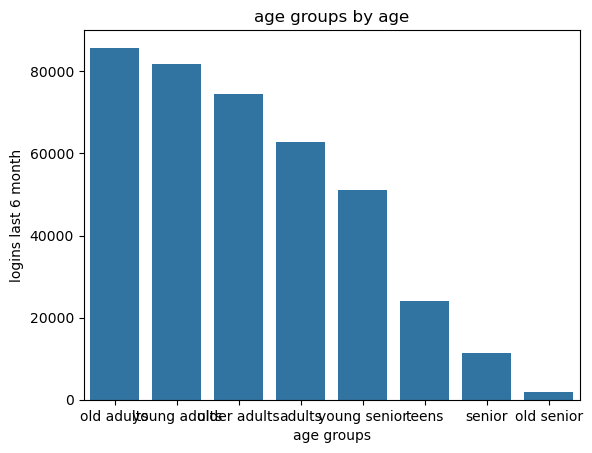

In [35]:
# Checking 
sns.barplot(data= most_clients)
plt.title("age groups by age")
plt.xlabel("age groups")
plt.ylabel("logins last 6 month")

In [36]:
# Who are the clients by tenure

<Axes: ylabel='client_tenure_yr'>

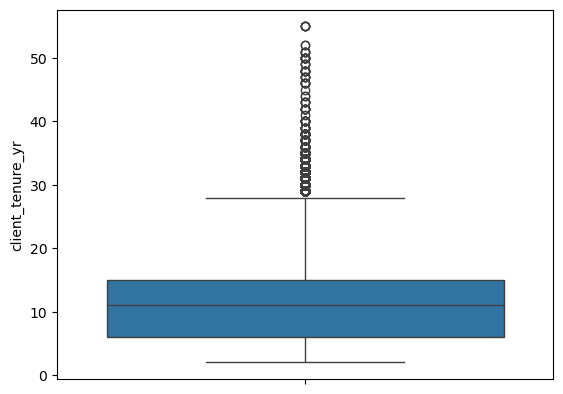

In [37]:
sns.boxplot(data=df_clients["client_tenure_yr"])

<Axes: ylabel='client_tenure_yr'>

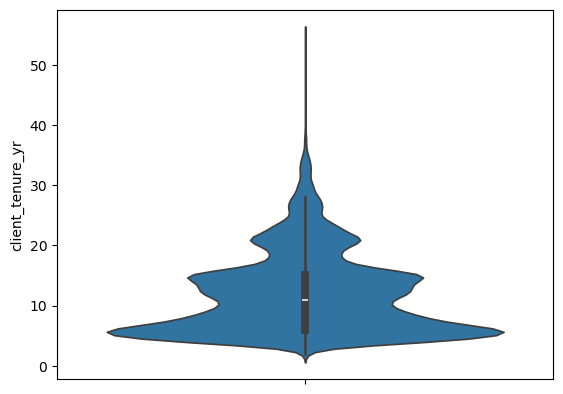

In [38]:
sns.violinplot(data=df_clients["client_tenure_yr"])

Text(0.5, 1.0, 'Client Age vs. Client Tenure (Years)')

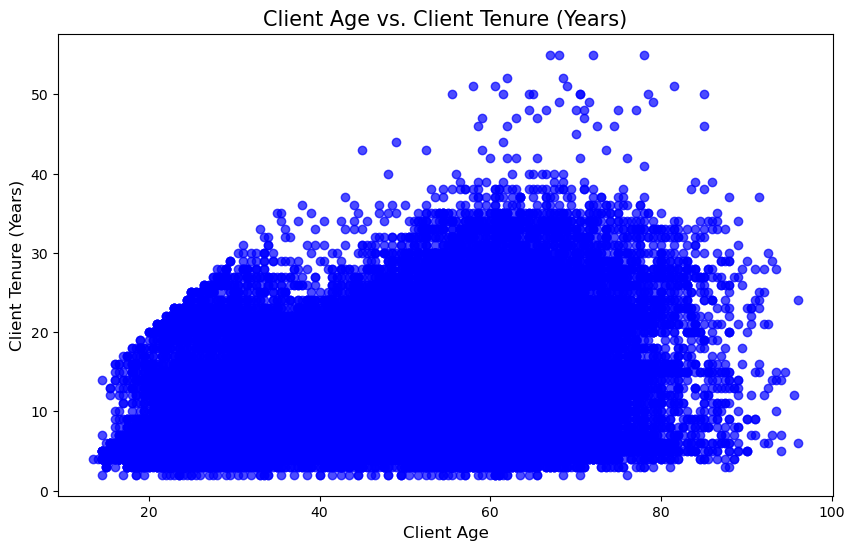

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clients['client_age'], df_clients['client_tenure_yr'], color='blue', alpha=0.7)
plt.xlabel('Client Age', fontsize=12)
plt.ylabel('Client Tenure (Years)', fontsize=12)
plt.title('Client Age vs. Client Tenure (Years)', fontsize=15)

Sorting df_concat and trying to calculate time of steps

In [28]:
# Joined Clients with the Roster an dropped the NaN Values
df_client_joined = pd.merge(df_clients,df_roster, how="left", on="client_id")
df_client_joined_cleaned = df_client_joined.dropna()

In [46]:
# Df_concat Sorted and time_diff_in_minutes

# With this we are able to analyze
df_concat_joined_sorted = df_concat_joined.sort_values(by=['client_id', 'visit_id', 'date_time'])
df_concat_joined_sorted['time_diff_in_minutes'] = df_concat_joined_sorted.groupby(['client_id', 'visit_id'])['date_time'].diff().dt.total_seconds() / 60

CALCULATING 
COMPLETION RATE

In [121]:
completion_rate_control = df_concat_joined_sorted[(df_concat_joined_sorted["finished"] == "yes") & (df_concat_joined_sorted["Variation"] == "Control")]["visit_id"].nunique()/df_concat_joined_sorted[df_concat_joined_sorted["Variation"]=="Control"]["visit_id"].nunique()

F"Completion Rate Test = {completion_rate_control}"

'Completion Rate Test = 0.46000186399080434'

In [122]:
completion_rate_test = df_concat_joined_sorted[(df_concat_joined_sorted["finished"] == "yes") & (df_concat_joined_sorted["Variation"] == "Test")]["visit_id"].nunique()/df_concat_joined_sorted[df_concat_joined_sorted["Variation"]=="Test"]["visit_id"].nunique()

F"Completion Rate Test = {completion_rate_test}"


'Completion Rate Test = 0.48066566135286515'

In [124]:
all_completion_rate = df_concat_joined_sorted[df_concat_joined_sorted["finished"] == "yes"]["visit_id"].nunique()/df_concat_joined_sorted["visit_id"].nunique()
F"Completion Rate = {completion_rate*100} %"

'Completion Rate = 47.02983888447366 %'

Calculating which visit ID turned into COMPLETE CONFIRM

In [103]:
# Adding a column for every visit which led to finished and go through all 4 steps
finished_list = filter_complete_visit(df_concat_joined_sorted)
df_concat_joined_sorted["finished"] = df_concat_joined_sorted["visit_id"].apply(lambda x:"yes" if x in finished_list else "no" )

Text(0.5, 1.0, 'Client Age vs. Client Tenure (Years)')

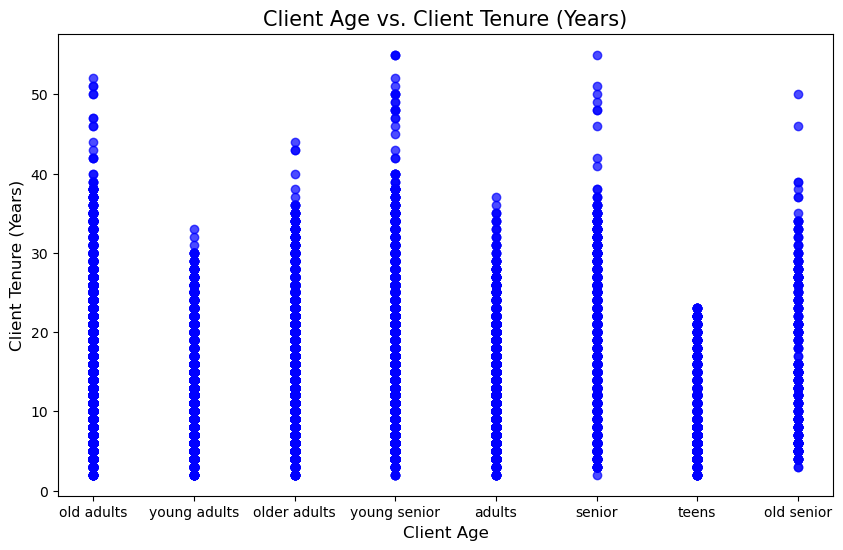

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clients['client_age_group'], df_clients['client_tenure_yr'], color='blue', alpha=0.7)
plt.xlabel('Client Age', fontsize=12)
plt.ylabel('Client Tenure (Years)', fontsize=12)
plt.title('Client Age vs. Client Tenure (Years)', fontsize=15)

In [52]:
# Calculating call categorized by age group
average_calls_by_age_variation = df_client_joined_cleaned.groupby(['client_age_group', 'Variation'])['calls_6_mnth'].mean().reset_index()

In [48]:
# How many reached
df_concat_joined_sorted["process_step"].value_counts()

process_step
start      101153
step_1      68210
step_2      56672
step_3      48264
confirm     42936
Name: count, dtype: int64

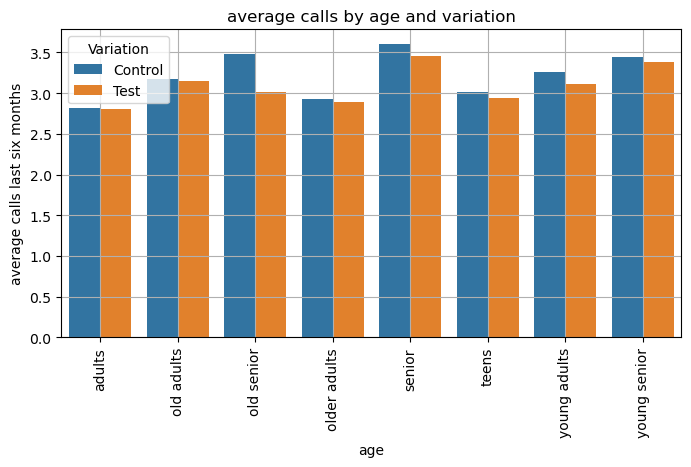

In [53]:
plt.figure(figsize=(8, 4))
sns.barplot(x='client_age_group', y='calls_6_mnth', hue='Variation', data=average_calls_by_age_variation)
plt.title('average calls by age and variation')
plt.xlabel('age')
plt.ylabel('average calls last six months')
plt.legend(title='Variation')
plt.grid(True)
plt.xticks(rotation= 90)
plt.show()

In [ ]:
# Adding a column for every visit which led to finished and go through all 4 steps
finished_list = filter_complete_visit(df_concat_joined_sorted)
df_concat_joined_sorted["finished"] = df_concat_joined_sorted["visit_id"].apply(lambda x:"yes" if x in finished_list else "no" )
len(finished_list)  
df_concat_joined_sorted[df_concat_joined_sorted["finished"] == "yes"]["visit_id"].nunique()

In [57]:
# HYPOTHESESTEST: Two Sample T-test
# HO no difference in number of calls between Test & Control
# H1 there is difference between number of calls between Test & Control 
import scipy.stats as st

In [59]:
df_client_joined_cleaned

,client_id,client_tenure_yr,client_tenure_mnth,client_age,gender,num_accts,balance,calls_6_mnth,logons_6_mnth,client_age_group,Variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,old adults,Test
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,old adults,Control
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,young adults,Test
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,older adults,Test
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,young adults,Control
...,...,...,...,...,...,...,...,...,...,...,...
50483,1780858,21.0,262.0,68.5,M,3.0,372100.59,6.0,9.0,young senior,Test
50484,6967120,21.0,260.0,68.5,M,3.0,4279873.38,6.0,9.0,young senior,Control
50485,5826160,20.0,249.0,56.5,F,2.0,44837.16,2.0,5.0,old adults,Test
50486,8739285,19.0,229.0,69.5,F,2.0,44994.24,1.0,4.0,young senior,Test


In [68]:
# Calculating Statistical Stuff

test = df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Test"]["calls_6_mnth"]
control= df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Control"]["calls_6_mnth"]

M1 = test.mean()
M2 = control.mean()
SD1 = test.std(ddof=1)
SD2 = control.std(ddof=1)
n1 = len(test)
n2 = len(control)

In [67]:
st.ttest_ind(test,control, equal_var=False)

TtestResult(statistic=-3.348638397521119, pvalue=0.0008127052569859838, df=49284.73108549173)

In [69]:
SD_pooled = np.sqrt(((n1 - 1) * SD1**2 + (n2 - 1) * SD2**2) / (n1 + n2 - 2))
cohens_d = (M1 - M2) / SD_pooled
cohens_d

-0.02996734220411194

In [70]:
# p-value < 0.05: assuming there is no difference it is not likely to see no difference in sample: reject null hypotheses.
# effectsize: -0.02 very small, not relevant

## 2.KPI: User Satisfaction Based on Logins in the Last 6 Months
Description: Evaluate user satisfaction through the frequency of user logins in the past 6 months, with more frequent logins suggesting a positive user experience and strong interest in the platform.

In [71]:
# H0: there is no difference between T & C in average of logins 
# H1: there is a difference between T & C in avergae of logins

In [73]:
df_Test_log = df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Test"]["logons_6_mnth"]
df_Control_log= df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Control"]["logons_6_mnth"]
st.ttest_ind(df_Test_log,df_Control_log, equal_var=False)

TtestResult(statistic=-3.2197513200195096, pvalue=0.0012838496093246267, df=49272.643050265775)

In [74]:
test_log= df_client_joined_cleaned[df_client_joined_cleaned['Variation']=='Test']['logons_6_mnth']
control_log= df_client_joined_cleaned[df_client_joined_cleaned['Variation']=='Control']['logons_6_mnth']

M1_log = test_log.mean() 
M2_log = control_log.mean()  
SD1_log = test_log.std(ddof=1) 
SD2_log = control_log.std(ddof=1)  
n1_log = len(test_log) 
n2_log = len(control_log)  

In [75]:
SD_pooled = np.sqrt(((n1_log - 1) * SD1_log**2 + (n2_log - 1) * SD2_log**2) / (n1_log + n2_log - 2))  #cohens d
cohens_d = (M1_log - M2_log) / SD_pooled
cohens_d

-0.028815745600392826

In [76]:
# p-values: < 0.05 : there is a difference
# effectsize: -0.02: very small, not relevant

## 3. KPI: User Satisfaction Based on Balance Amount
Description: Gauge user satisfaction by examining the balance amount of a user's account, as a higher balance can indicate a positive financial experience and trust in the platform.

In [77]:
# KPI balance 
#H0: no difference in balance
#H1: difference in balance     -> p-value > 0.05: don't reject HO! 

In [78]:
df_Test_bal = df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Test"]["balance"]
df_Control_bal= df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Control"]["balance"]
st.ttest_ind(df_Test_bal,df_Control_bal, equal_var=True)

TtestResult(statistic=-0.4299225555792149, pvalue=0.6672538243459556, df=50155.0)

## 4. KPI: User Satisfaction Based on the Number of Accounts
Description: Assess user satisfaction by counting the number of accounts a user holds on the platform, as a higher account number may reflect stronger engagement and satisfaction with the services offered.

In [79]:
# H0: no difference in account number
# H1: difference in account number      

In [80]:
df_Test_acc = df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Test"]["num_accts"]
df_Control_acc= df_client_joined_cleaned[df_client_joined_cleaned["Variation"]=="Control"]["num_accts"]
st.ttest_ind(df_Test_acc,df_Control_acc, equal_var=False)

TtestResult(statistic=-2.012832721884745, pvalue=0.044137689068619035, df=49005.313362693)

In [81]:
# effectsize:
control_acc= df_client_joined_cleaned[df_client_joined_cleaned['Variation']=='Control']["num_accts"]
control_acc
test_acc= df_client_joined_cleaned[df_client_joined_cleaned['Variation']=='Test']["num_accts"]
test_acc

M1_acc = test_acc.mean() 
M2_acc = control_acc.mean()  
SD1_acc = test_acc.std(ddof=1) 
SD2_acc = control_acc.std(ddof=1)  
n1_acc = len(test_acc) 
n2_acc = len(control_acc)  

In [82]:
SD_pooled = np.sqrt(((n1_acc - 1) * SD1_acc**2 + (n2_acc - 1) * SD2_acc**2) / (n1_acc + n2_acc - 2))
cohens_d = (M1_acc - M2_acc) / SD_pooled
cohens_d

-0.018037883758176016

In [83]:
# p-value (slightly) < 0.05: reject H0
# effectsize: -0.018 : not relevant 

In [89]:
# error rate
df_concat_joined = df_concat_joined.sort_values(by=['visit_id', 'date_time'])
df_concat_joined['previous_step'] = df_concat_joined.groupby('visit_id')['process_step'].shift(1) #shifts values on cell down 

In [101]:
df_concat_joined.groupby('visit_id')['process_step'].shift(1)

108614        NaN
108613    confirm
240562        NaN
240561      start
240560     step_1
           ...   
97222         NaN
97221       start
97220      step_1
97219      step_2
97218      step_1
Name: process_step, Length: 317235, dtype: object

In [90]:
step_mapping = {'start': 0, 'step1': 1, 'step2': 2, 'step3': 3, 'confirm': 4}
df_concat_joined['process_step_numeric'] = df_concat_joined['process_step'].map(step_mapping)
df_concat_joined = df_concat_joined.sort_values(by=['visit_id', 'date_time'])
df_concat_joined['previous_step_numeric'] = df_concat_joined.groupby('visit_id')['process_step_numeric'].shift(1)
df_concat_joined['is_error'] = df_concat_joined['process_step_numeric'] < df_concat_joined['previous_step_numeric']

In [98]:
df_concat_joined[df_concat_joined["visit_id"]=="100618014_41463020246_787063"]

,client_id,visitor_id,visit_id,process_step,date_time,Variation,year_month,previous_step,process_step_numeric,previous_step_numeric,is_error
521140,4389198,729937373_63248482072,100618014_41463020246_787063,confirm,2017-05-11 09:13:00,Test,2017-05,confirm,4.0,NaN,False
521125,4389198,729937373_63248482072,100618014_41463020246_787063,start,2017-05-11 09:13:46,Test,2017-05,confirm,0.0,4.0,True
521124,4389198,729937373_63248482072,100618014_41463020246_787063,step_1,2017-05-11 09:21:51,Test,2017-05,start,NaN,0.0,False


In [100]:
df_concat[df_concat["visit_id"]=="100618014_41463020246_787063"]

,client_id,visitor_id,visit_id,process_step,date_time
177983,4389198,729937373_63248482072,100618014_41463020246_787063,step_1,2017-05-11 09:21:51
177984,4389198,729937373_63248482072,100618014_41463020246_787063,start,2017-05-11 09:13:46
177985,4389198,729937373_63248482072,100618014_41463020246_787063,start,2017-05-11 09:13:46
177999,4389198,729937373_63248482072,100618014_41463020246_787063,confirm,2017-05-11 09:13:00


In [94]:
df_concat_joined[df_concat_joined["is_error"] == True]

,client_id,visitor_id,visit_id,process_step,date_time,Variation,year_month,previous_step,process_step_numeric,previous_step_numeric,is_error
521125,4389198,729937373_63248482072,100618014_41463020246_787063,start,2017-05-11 09:13:46,Test,2017-05,confirm,0.0,4.0,True
46955,1181373,63399771_40264961342,101680890_99989873555_20306,start,2017-04-06 23:07:25,Test,2017-04,confirm,0.0,4.0,True
530272,9719474,494497404_19580991399,102039130_96083762708_562998,start,2017-05-29 14:44:08,Control,2017-05,NaN,0.0,4.0,True
148074,1081771,177562071_65278452379,102040676_43919492336_211555,start,2017-03-29 11:19:51,Test,2017-03,confirm,0.0,4.0,True
233982,7516259,254175251_5339168232,103844930_39480104147_119972,start,2017-04-14 16:26:55,Control,2017-04,NaN,0.0,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...
194532,2989514,911407231_22677757642,992501315_52187662897_578510,start,2017-04-12 17:34:12,Control,2017-04,confirm,0.0,4.0,True
229919,609351,607276246_21737071573,992939045_35471907532_926842,start,2017-04-05 21:53:18,Control,2017-04,confirm,0.0,4.0,True
161045,5023117,466389680_89636478437,992941276_23591768324_516622,start,2017-03-29 11:12:55,Test,2017-03,confirm,0.0,4.0,True
173435,2657062,384438953_2039351232,993877099_76368524525_812383,start,2017-04-19 22:29:40,Control,2017-04,confirm,0.0,4.0,True


In [102]:
print(df_concat_joined[['client_id', 'date_time', 'process_step', 'previous_step_numeric', 'is_error']])



        client_id           date_time process_step  previous_step_numeric  \
108614    3561384 2017-04-26 13:22:17      confirm                    NaN   
108613    3561384 2017-04-26 13:23:09      confirm                    4.0   
240562    7338123 2017-04-09 16:20:56        start                    NaN   
240561    7338123 2017-04-09 16:21:12       step_1                    0.0   
240560    7338123 2017-04-09 16:21:21       step_2                    NaN   
...           ...                 ...          ...                    ...   
97222     6627522 2017-04-21 23:49:11        start                    NaN   
97221     6627522 2017-04-21 23:49:22       step_1                    0.0   
97220     6627522 2017-04-21 23:50:16       step_2                    NaN   
97219     6627522 2017-04-21 23:51:00       step_1                    NaN   
97218     6627522 2017-04-21 23:51:09        start                    NaN   

        is_error  
108614     False  
108613     False  
240562     False  